# Demonstration: QCNN algorithm

In [2]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars

import sys
sys.path.insert(0, '../')
import vqe as vqe
import qcnn as qcnn
import losses as losses
import visualization as qplt
##############

In [3]:
myqcnn = qcnn.qcnn(vqe.load_vqe('./ANNNIN4n100.pkl'), qcnn.qcnn_circuit, n_outputs = 2)

myqcnn = qcnn.qcnn(vqe.load_vqe('../data/vqe_annni.pkl'), qcnn.qcnn_circuit, n_outputs = 2)

In [4]:
side = 100

In [24]:
train_index = np.arange(0,2*side-1)

In [25]:
np.sort(train_index)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [26]:
myqcnn.train(.1, 1000, train_index, losses.cross_entropy_multiclass, circuit=True, plot=False, inject = False)

+--- CIRCUIT ---+
0: ──||──||──RY(0.00)──RX(4.00)──||──RY(8.00)─────||──RY(10.00)─╭C──RY(13.00)──||
1: ──||──||──RY(1.00)──RX(5.00)──||──RY(8.00)─╭C──||──RY(11.00)─╰X──RY(14.00)──||
2: ──||──||──RY(2.00)──RX(6.00)──||──RY(9.00)─╰X──||──RY(11.00)─╭C──RY(15.00)──||
3: ──||──||──RY(3.00)──RX(7.00)──||──RY(9.00)─────||──RY(12.00)─╰X──RY(16.00)──||

──╭C──────────────────────────╭C──────────────────────────────────────||─────────────────────────
──╰ControlledOperation(17.00)─╰ControlledOperation(18.00)──RX(21.00)──||─╭C──RY(23.00)──RX(25.00)
──╭C──────────────────────────╭C──────────────────────────────────────||─│───────────────────────
──╰ControlledOperation(19.00)─╰ControlledOperation(20.00)──RX(22.00)──||─╰X──RY(24.00)──RX(26.00)

─────────────┤       
───RY(27.00)─┤  Probs
─────────────┤       
───RY(28.00)─┤  Probs


Cost: 0.1711222529411316: 100%|████████████| 1000/1000 [00:08<00:00, 112.15it/s]


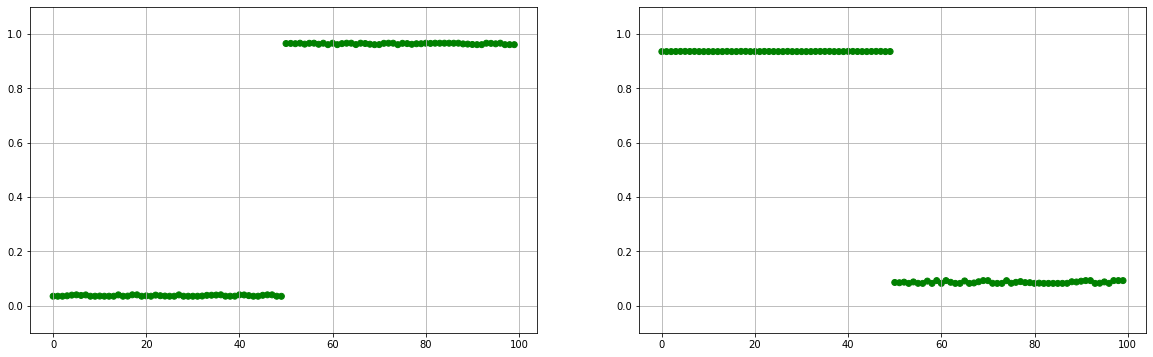

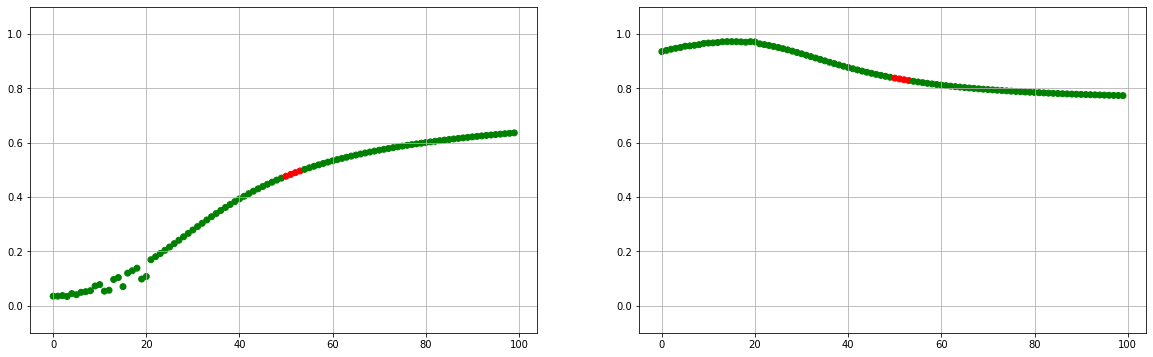

In [27]:
qplt.show_QCNN_classification2D(myqcnn)

In [28]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, Normalize
import plotly.graph_objects as go
import pandas as pd
from orqviz.scans import perform_2D_scan, plot_2D_scan_result
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)

In [118]:
def show_QCNN_classificationANNNI(qcnnclass, hard_thr = True, lines = False):
    circuit = qcnnclass.vqe_qcnn_circuit
    side = int(np.sqrt(qcnnclass.n_states))
    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        circuit(params_vqe, params)

        if qcnnclass.n_outputs == 1:
            return qml.probs(wires=self.N - 1)
        else:
            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
        
    vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))

    if hard_thr:
        predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis = 2))
        c = []
        for pred in predictions:
            if (pred == [0,1]).all():
                c.append(0)
            elif (pred == [1,1]).all():
                c.append(1)
            elif (pred == [1,0]).all():
                c.append(2)
            else: c.append(3)

        phases = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "limegreen"])
        norm = mpl.colors.BoundaryNorm(np.arange(0,4), phases.N) 
        plt.imshow( np.rot90(np.rot90(np.rot90(np.reshape(c, (side, side) )))), 
                                      cmap = phases, norm = norm, origin='lower')
    else:
        predictions = np.array(vcircuit(qcnnclass.vqe_params) )
        c = []
        
        # define color map 
        color_map = {1: np.array([255, 0, 0]), # red
                     2: np.array([0, 255, 0]), # green
                     3: np.array([0, 0, 255])} # blue
        
        rgb_probs = np.ndarray(shape=(side*side, 3), dtype=float)
        
        for i, pred in enumerate(predictions):
            p0 = 1 - np.sum(np.abs(pred[:,0] - [0,1]))/2
            p1 = 1 - np.sum(np.abs(pred[:,0] - [1,1]))/2
            p2 = 1 - np.sum(np.abs(pred[:,0] - [1,0]))/2
            
            rgb_probs[i] = [p0*255,p1*255,p2*255]
        rgb_probs = np.rot90(np.rot90(np.rot90(np.reshape(rgb_probs, (side,side,3)) )))
        
        plt.imshow(rgb_probs.astype(np.uint8), origin='lower')
        
    plt.title('Classification of ANNNI states')
    plt.ylabel('L')
    plt.xlabel('K')
    
    plt.yticks(np.linspace(0,side-1,5), labels = np.round(np.linspace(0,2,5),2) )
    
    plt.xticks(np.linspace(0,side-1,5), labels = np.round(np.linspace(0,-1,5),2) )
    
    x = np.linspace(.5,1)
    y = 1.05 * np.sqrt((x-.5)*(x-.1))
    
    plt.plot(side*x,y*side/2)
    
    plt.show()
    
    return x,y

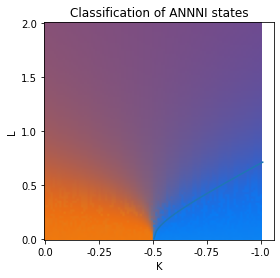

In [123]:
_ = show_QCNN_classificationANNNI(myqcnn, hard_thr = False)

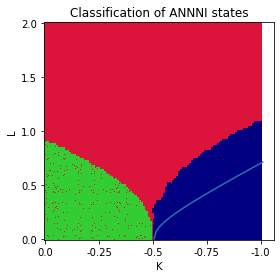

In [126]:
x, y = show_QCNN_classificationANNNI(myqcnn, hard_thr = True)

In [62]:
1.05*np.sqrt(.5*.9)

0.7043614129124338

In [63]:
b2x_scaled = np.linspace(.5,1)

In [64]:
(1.05*np.sqrt( (b2x_scaled - .5)*(b2x_scaled - .1) ) )

tensor([0.        , 0.06793229, 0.09725833, 0.12055357, 0.14084294,
        0.15927931, 0.17644448, 0.19267849, 0.20819928, 0.22315571,
        0.23765435, 0.25177432, 0.265576  , 0.27910663, 0.29240383,
        0.30549809, 0.31841444, 0.3311737 , 0.34379336, 0.35628826,
        0.36867108, 0.38095275, 0.39314275, 0.40524936, 0.41727982,
        0.42924055, 0.44113721, 0.45297486, 0.464758  , 0.47649068,
        0.48817653, 0.49981884, 0.51142059, 0.52298447, 0.53451294,
        0.54600824, 0.55747243, 0.56890738, 0.58031483, 0.59169637,
        0.60305345, 0.61438745, 0.62569961, 0.63699109, 0.64826299,
        0.65951629, 0.67075194, 0.68197081, 0.69317371, 0.70436141], requires_grad=True)